In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

In [22]:
# Load dataset
df = pd.read_csv('transfusion.data')

In [23]:
# Rename target column
df.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace=True)


In [24]:
# Basic info and target distribution
print(df.info())
print(df['target'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Recency (months)       748 non-null    int64
 1   Frequency (times)      748 non-null    int64
 2   Monetary (c.c. blood)  748 non-null    int64
 3   Time (months)          748 non-null    int64
 4   target                 748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None
target
0    570
1    178
Name: count, dtype: int64


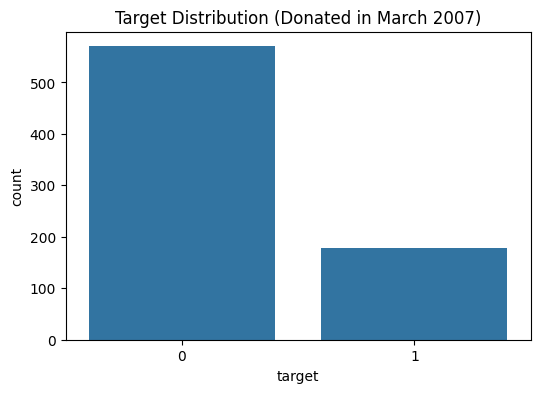

In [25]:
# EDA Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title('Target Distribution (Donated in March 2007)')
plt.show()

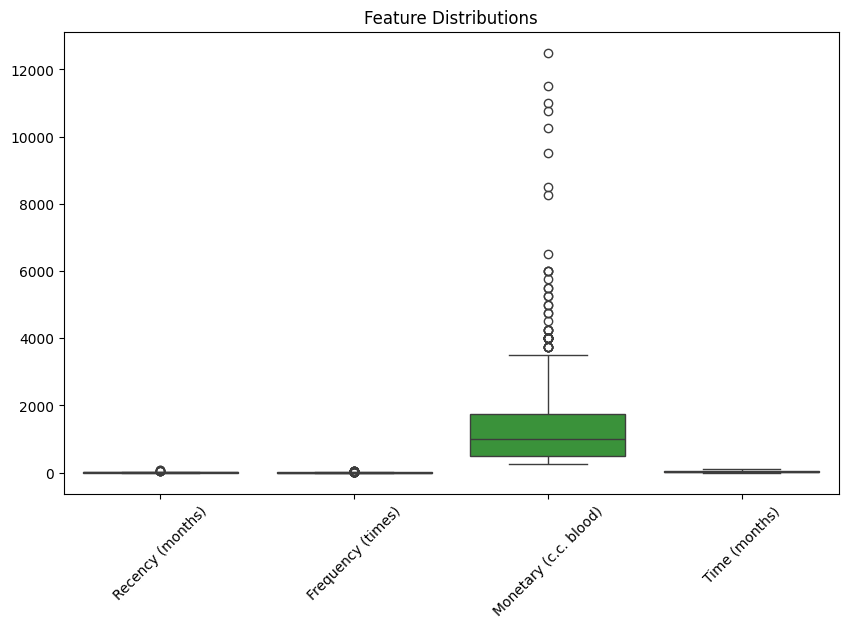

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df.drop(columns=['target']))
plt.title('Feature Distributions')
plt.xticks(rotation=45)
plt.show()

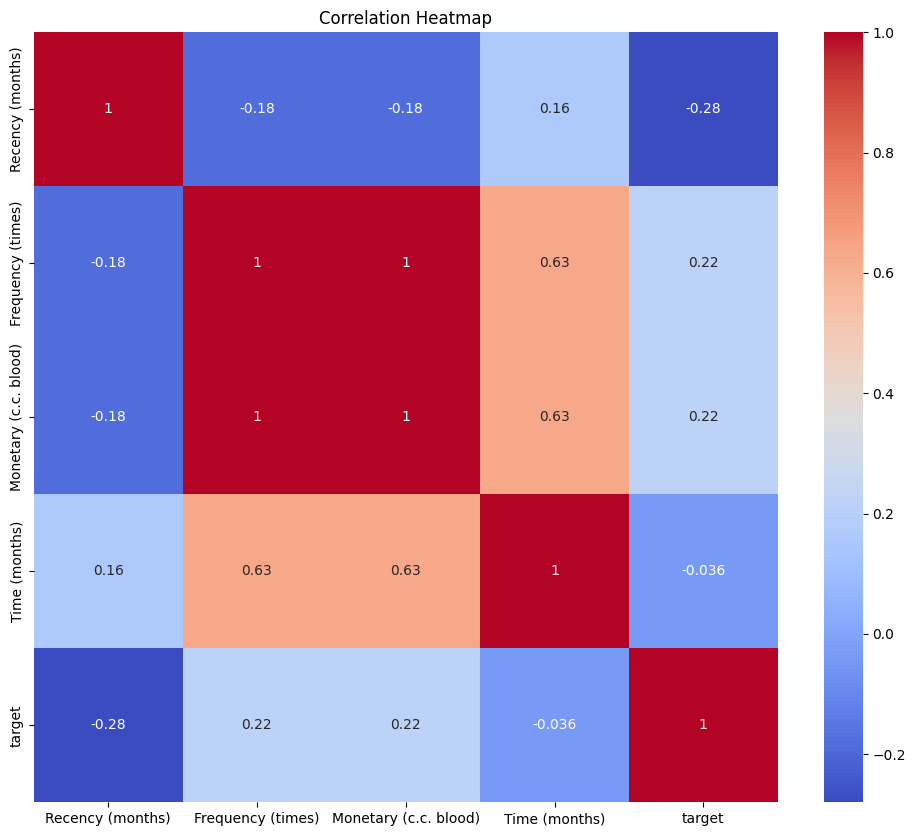

In [27]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# Define features and target
X = df.drop(columns=['target'])
y = df['target']

In [29]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [31]:
# Train Logistic Regression without hyperparameter tuning
logreg = LogisticRegression(random_state=42, max_iter=10000)
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [32]:
y_pred = logreg.predict(X_test)
acc_no_tune = accuracy_score(y_test, y_pred)
print("Accuracy without hyperparameter tuning:", acc_no_tune)
print("Classification Report without tuning:\n", classification_report(y_test, y_pred))
print("Confusion Matrix without tuning:\n", confusion_matrix(y_test, y_pred))


Accuracy without hyperparameter tuning: 0.7377777777777778
Classification Report without tuning:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85       165
           1       0.56      0.08      0.14        60

    accuracy                           0.74       225
   macro avg       0.65      0.53      0.50       225
weighted avg       0.69      0.74      0.66       225

Confusion Matrix without tuning:
 [[161   4]
 [ 55   5]]


In [33]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'penalty': ['l2'],  # For simplicity: elasticnet/l1 requires saga solver and extra params
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg']  # Compatible solvers with l2 penalty
}

In [34]:
grid_search = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [35]:
best_logreg = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


Accuracy with hyperparameter tuning: 0.7377777777777778
Classification Report with tuning:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85       165
           1       0.56      0.08      0.14        60

    accuracy                           0.74       225
   macro avg       0.65      0.53      0.50       225
weighted avg       0.69      0.74      0.66       225



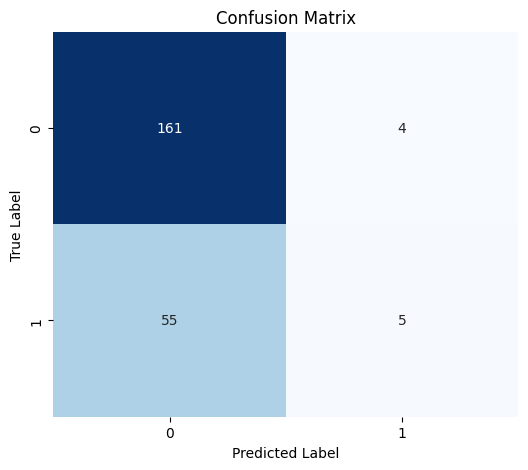

In [39]:
# Predict with tuned model
y_pred_tuned = best_logreg.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
print("Accuracy with hyperparameter tuning:", acc_tuned)
print("Classification Report with tuning:\n", classification_report(y_test, y_pred_tuned))
cm=confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


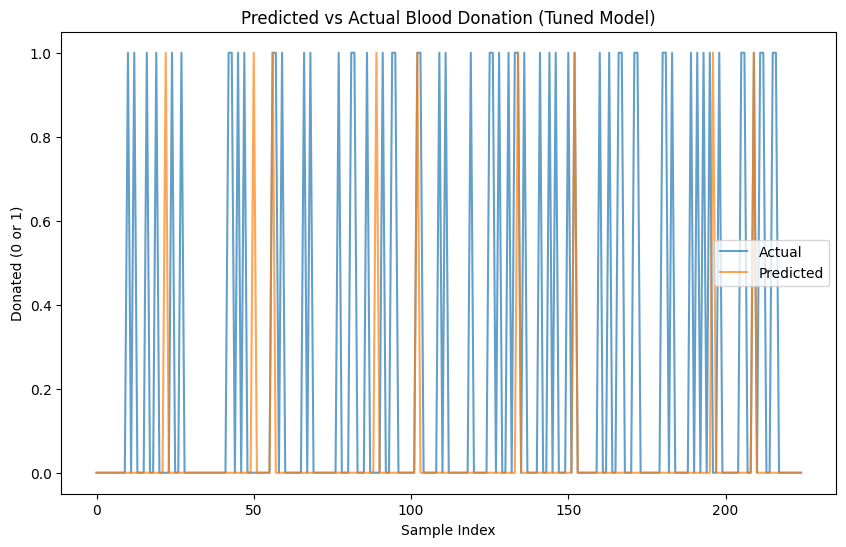

In [37]:
# Plot predicted vs actual using tuned model
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(range(len(y_pred_tuned)), y_pred_tuned, label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual Blood Donation (Tuned Model)')
plt.xlabel('Sample Index')
plt.ylabel('Donated (0 or 1)')
plt.legend()
plt.show()

In [38]:

# Export tuned model
joblib.dump(best_logreg, '23MID0171-logreg_blood_donation_tuned_model.pkl')
print("Tuned model exported as logreg_blood_donation_tuned_model.pkl")

Tuned model exported as logreg_blood_donation_tuned_model.pkl
